# Betts diurnal lcl plots

Take a domain with mandatory variables and generate the fields required to plot [Betts 2009 fig 10](https://agupubs.onlinelibrary.wiley.com/doi/10.3894/James.2009.1.4)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import netCDF4 as nc


# Handy metpy tutorial working with xarray:
# https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#sphx-glr-tutorials-xarray-tutorial-py
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
from metpy.plots import SkewT

In [2]:
the_data = "GFDL-ESM4-piControl.nc"

In [3]:
data_in = xr.open_dataset(f"data/{the_data}", decode_times=False).metpy.quantify()
data_in["time"] = cftime.num2date(data_in.time, "minutes since 0000-01-01 00:00:00", calendar="noleap", has_year_zero=True)
#data_in['time'] = cftime.datetime.fromordinal(data_in.time, calendar='noleap') # manually reconvert to cftime

In [4]:
ps = 100000 * units.Pa # temporary hack, should interpolate pressure from daily timeseries (modify `get_domain`)

In [5]:
specific_humidity = data_in.huss#[np.isnan(data_in.huss.values) == False]#.metpy.quantify()
surface_temp = data_in.tas#[np.isnan(hourly_data.tas.values) == False].metpy.quantify()
data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)

/Users/phil/mini310/envs/climphys/lib/python3.10/site-packages/metpy/calc/thermo.py:1341: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


In [6]:
spatial_average = data_in.mean(dim=("lat", "lon"))

In [ ]:
# need to add a step here to select only warm months with PBL development. could do:
# summer = my_ds.time[my_ds.time.dt.season == "JJA"]

In [7]:
# separate by soil moisture by rounding to nearest kg/m3 in top soil layer
spatial_average["soil_moisture_grp"] = ((spatial_average.mrsos / 3).round() * 3)[np.isnan(spatial_average.mrsos.values) == False]

In [8]:
gbysoil = spatial_average.groupby(spatial_average.soil_moisture_grp)
gbysoil.groups.keys()

dict_keys([24.0, 27.0, 30.0, 33.0, 36.0, 39.0])

In [9]:
min(gbysoil.groups.keys())

24.0

In [15]:
gbysoil.groups.keys()

dict_keys([24.0, 27.0, 30.0, 33.0, 36.0, 39.0])

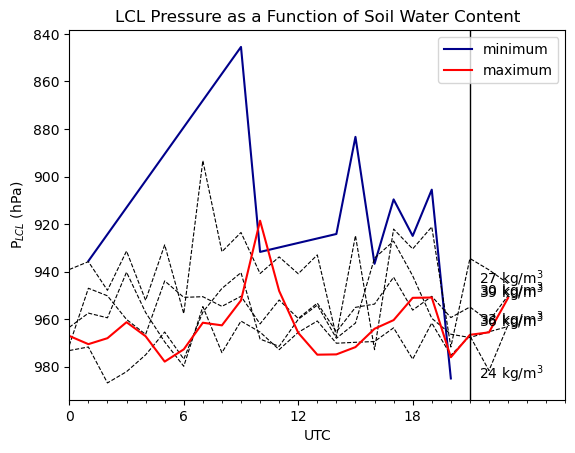

In [14]:
# calculate and plot the average diurnal cycle of lcl height

fig, ax = plt.subplots()
for key in gbysoil.groups.keys():
    # group by hour
    hourly_data = gbysoil[key].groupby(gbysoil[key].time.dt.hour).mean(dim="time")  
    
    # find and plot the lcl
    plcl, tlcl = mpcalc.lcl(ps, hourly_data.tas, hourly_data.td)
    plcl_hpa = plcl / 100
    
    if key == min(gbysoil.groups.keys()):
        plot_kwargs = {"color":"darkblue","label":"minimum"}
    elif key == max(gbysoil.groups.keys()):
        plot_kwargs = {"color":"red","label":"maximum"}
    else:
        plot_kwargs = {"color":"black", "linestyle":"--", "linewidth":0.8}
    
    ax.plot(hourly_data.hour, plcl_hpa[np.isnan(plcl) == False], **plot_kwargs)
    ax.annotate(f"{round(key)} kg/m$^3$", (21.5, plcl_hpa[-1]))
    

plt.gca().invert_yaxis()
ax.set_xlabel("UTC")
ax.set_ylabel("P$_{LCL}$ (hPa)")
ax.axvline(21, color="k", linewidth=1)


ax.xaxis.set_major_locator(MultipleLocator(6))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_xticks((0,6,12,18))
ax.set_xlim(0,26)
ax.set_title("LCL Pressure as a Function of Soil Water Content");
ax.legend(loc="upper right")   